In [169]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [126]:
cars_df = pd.read_csv("/kaggle/input/craigslist-carstrucks-data/vehicles.csv")

## EDA and data cleaning

In [127]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [128]:
cars_df.rename(columns={ "odometer": "mileage" }, inplace=True)

In [129]:
cars_df.describe()

,id,price,year,mileage,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [130]:
# drop all data with missing values in following columns
cars_df.dropna(subset=["manufacturer", "fuel", "mileage", "year"], inplace=True)
cars_df.shape

(403068, 26)

In [131]:
# drop all data of cars made before 2008
indices_of_cars_before_2008 = cars_df[cars_df['year'] <= 2008].index
cars_df.drop(labels=indices_of_cars_before_2008, inplace=True)
cars_df.shape

(301593, 26)

In [132]:
# drop columns with little to no predictive value on price
cars_df.drop(columns=["url", "id", "region_url", "county", "image_url", 
                        "description", "model", "VIN", "long", "lat", 
                        "region", "posting_date"], 
             inplace=True)

cars_df.shape

(301593, 14)

In [133]:
# drop all data of cars with mileage in excess of 250k
indices_of_cars_with_excess_mileage = cars_df[cars_df["mileage"] > 250000].index
cars_df.drop(labels=indices_of_cars_with_excess_mileage, inplace=True)
cars_df.shape

(300370, 14)

In [134]:
# drop all data of cars with unrealistic prices, under $1000
indices_of_cars_with_unrealistic_prices = cars_df[cars_df["price"] < 1000].index
cars_df.drop(labels=indices_of_cars_with_unrealistic_prices, inplace=True)
cars_df.shape

(264887, 14)

In [135]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264887 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         264887 non-null  int64  
 1   year          264887 non-null  float64
 2   manufacturer  264887 non-null  object 
 3   condition     160504 non-null  object 
 4   cylinders     147487 non-null  object 
 5   fuel          264887 non-null  object 
 6   mileage       264887 non-null  float64
 7   title_status  260569 non-null  object 
 8   transmission  263720 non-null  object 
 9   drive         184726 non-null  object 
 10  size          62871 non-null   object 
 11  type          218259 non-null  object 
 12  paint_color   193031 non-null  object 
 13  state         264887 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 30.3+ MB


In [136]:
cars_df.describe()

,price,year,mileage
count,2.648870e+05,264887.000000,264887.000000
mean,3.956881e+04,2015.044053,74954.210852
std,6.238162e+06,3.112021,51813.560226
min,1.000000e+03,2009.000000,0.000000
25%,1.199500e+04,2013.000000,30164.000000
50%,2.039500e+04,2015.000000,68982.000000
75%,3.159000e+04,2018.000000,111431.500000
max,3.009549e+09,2022.000000,250000.000000


## Plot prices column

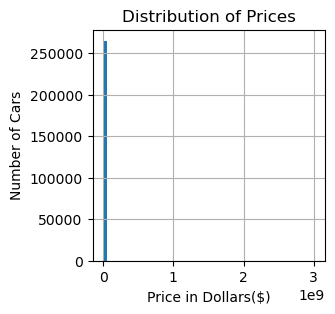

In [137]:
fig, ax = plt.subplots(figsize=(3,3))
cars_df["price"].hist(bins=50)
plt.xlabel("Price in Dollars($)")
plt.ylabel("Number of Cars")
plt.title("Distribution of Prices")
plt.show()

## Plot log of price column

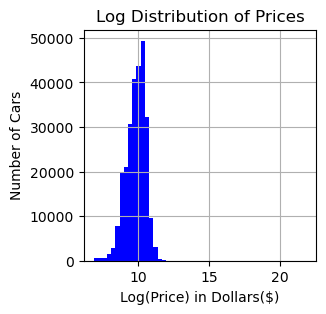

In [139]:
fig, ax = plt.subplots(figsize=(3,3))
cars_df["price"].apply(np.log).hist(bins=50, color="blue")
plt.xlabel("Log(Price) in Dollars($)")
plt.ylabel("Number of Cars")
plt.title("Log Distribution of Prices")
plt.show()

## Transform price into log(price)

In [140]:
cars_df["log(price)"] = cars_df["price"].apply(np.log)
cars_df.drop(columns=["price"], inplace=True)
cars_df = cars_df.astype(dtype={"log(price)": np.float16},
                         copy=False)
cars_df.shape

(264887, 14)

In [141]:
cars_df['log(price)'].head()

27    10.421875
28    10.023438
29    10.585938
30    10.343750
31     9.617188
Name: log(price), dtype: float16

## Plot mileage column

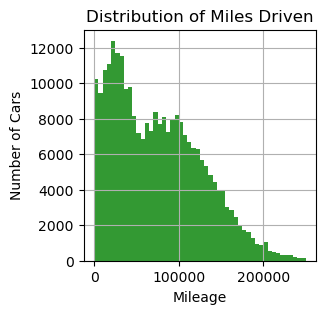

In [142]:
fig, ax = plt.subplots(figsize=(3,3))
cars_df["mileage"].hist(bins=50, color="green", alpha=0.8)
plt.xlabel("Mileage")
plt.ylabel("Number of Cars")
plt.title("Distribution of Miles Driven")
plt.show()

## Plot transformations of mileage column

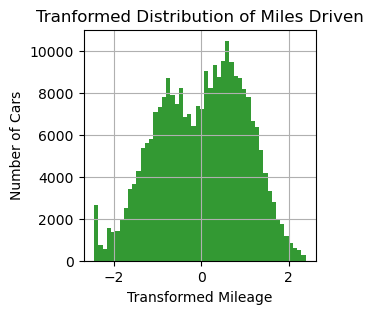

In [143]:
sqrt_mileage = (cars_df["mileage"] + 1).apply(np.sqrt)
mean_mileage = sqrt_mileage.mean()
std_mileage = sqrt_mileage.std()
standardized_mileage = (sqrt_mileage - mean_mileage) / std_mileage

fig, ax = plt.subplots(figsize=(3,3))
standardized_mileage.hist(bins=50, color="green", alpha=0.8)
plt.xlabel("Transformed Mileage")
plt.ylabel("Number of Cars")
plt.title("Tranformed Distribution of Miles Driven")
plt.show()

In [144]:
years_quanitites = cars_df["year"].value_counts()
year_car_made = years_quanitites.index
number_of_cars = years_quanitites.values

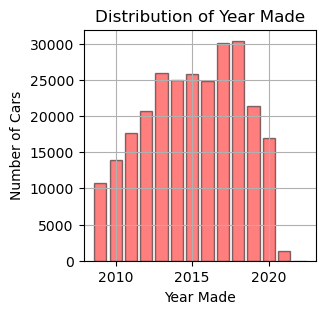

In [145]:
years_quanitites = cars_df["year"].value_counts()
year_car_made = years_quanitites.index
number_of_cars = years_quanitites.values

fig, ax = plt.subplots(figsize=(3,3))
ax.bar(x=year_car_made, height=number_of_cars, color="red", alpha=0.5, edgecolor='black')
plt.xlabel("Year Made")
plt.ylabel("Number of Cars")
plt.title("Distribution of Year Made")
plt.grid(True)
plt.show()

## Defining functions for feature engineering and preprocessing for training, validation, and test sets

In [158]:
def train_data_prep_year_column(train_df):
    max_year = train_df["year"].max()
    train_df["year"] /= max_year
    return train_df, max_year

def train_data_prep_mileage_column(train_df):
    sqrt_mileage = (train_df["mileage"] + 1).apply(np.sqrt)
    mean_mileage = sqrt_mileage.mean()
    std_mileage = sqrt_mileage.std()
    train_df["mileage"] = (train_df["mileage"] - mean_mileage) / std_mileage
    return train_df, mean_mileage, std_mileage

def valid_test_data_prep_year_column(valid_test_df, max_year):
    valid_test_df["year"] /= max_year
    return valid_test_df

def valid_test_data_prep_mileage_column(valid_test_df, mean_mileage, std_mileage):
    valid_test_df["mileage"] = (valid_test_df["mileage"] + 1).apply(np.log)
    valid_test_df["mileage"] = (valid_test_df["mileage"] - mean_mileage) / std_mileage
    return valid_test_df

In [159]:
# get the names of categorical columns for onehot encoding 
def get_columns_to_onehot(train_df):
    train_columns_to_onehot = train_df.columns
    columns_to_onehot = []
    total_categories = 0
    for car_column in train_columns_to_onehot:
        if car_column in ["price", "mileage", "year"]: continue
        all_categories = train_df[car_column].value_counts()
        print("column:", car_column, 'and number of categories:', len(all_categories))
        print("----------------------")
        columns_to_onehot.append(car_column)
        total_categories += len(all_categories)

    print('columns_to_onehot:', columns_to_onehot)
    print('total_categories:', total_categories)
    return columns_to_onehot

In [160]:
def train_data_columns_to_onehot(train_df, columns_to_onehot, onehot_encoder):

    # get the categorical columns
    data_for_onehot = train_df[columns_to_onehot]
    
    # fit Sklearn's OneHotEncoder with fit_transform() to training data
    onehot_encoded_data = onehot_encoder.fit_transform(data_for_onehot)

    # get the names of all categories that were onehot encoded by Sklearn
    onehot_categories = []
    for subarray in onehot_encoder.categories_:
        onehot_categories += list(subarray)

    # create a dataframe out of the onehot encoded columns only
    onehot_df = pd.DataFrame(data=onehot_encoded_data.toarray(),
                             columns= onehot_categories)

    # drop all categorical columns in the train dataframe
    category_columns_dropped_df = train_df.drop(columns=columns_to_onehot)
    onehot_encoded_train_df = pd.concat([category_columns_dropped_df.reset_index(drop=True), 
                                         onehot_df.reset_index(drop=True)],
                                         axis=1)
    
    # ensure all columns names are of type str
    onehot_encoded_train_df.columns = onehot_encoded_train_df.columns.astype(str)
    
    return onehot_encoded_train_df, onehot_categories

In [161]:
def valid_test_data_columns_to_onehot(valid_test_df, 
                                      columns_to_onehot, 
                                      onehot_categories, 
                                      onehot_encoder):

    # get the categorical columns
    data_for_onehot = valid_test_df[columns_to_onehot]
    
    # apply Sklearn's OneHotEncoder.transform() to already fitted training data
    onehot_encoded_data = onehot_encoder.transform(data_for_onehot)

    # create a dataframe out of the onehot encoded columns only
    onehot_df = pd.DataFrame(data=onehot_encoded_data.toarray(),
                             columns=onehot_categories)
    
    # drop all categorical columns in the valid/test dataframe
    category_columns_dropped_df = valid_test_df.drop(columns=columns_to_onehot)
    
    # join the remaining numerical columns dataframe with onehot encoded dataframe
    onehot_encoded_valid_test_df = pd.concat([category_columns_dropped_df.reset_index(drop=True), 
                                              onehot_df.reset_index(drop=True)],
                                             axis=1)
    
    # ensure all columns names are of type str
    onehot_encoded_valid_test_df.columns = onehot_encoded_valid_test_df.columns.astype(str)
    
    return onehot_encoded_valid_test_df

In [165]:
def full_train_prep(train_df, onehot_encoder):
    feature_engineering_params = {}
    
    # divide year column by max year
    train_df_year_transformed, max_year = train_data_prep_year_column(train_df)
    feature_engineering_params["max_year"] = max_year
    
    # apply log and then normalization on mileage column
    train_df_mileage_transformed, mean_mileage, std_mileage = train_data_prep_mileage_column(train_df_year_transformed)
    feature_engineering_params["mean_mileage"] = mean_mileage
    feature_engineering_params["std_mileage"] = std_mileage
    
    # get the categorical columns to onehot encode
    columns_to_onehot = get_columns_to_onehot(train_df_mileage_transformed)
    feature_engineering_params["columns_to_onehot"] = columns_to_onehot
    
    # onehot encode all remaining columns which are categorical
    onehot_encoded_train_df, onehot_categories = train_data_columns_to_onehot(train_df_mileage_transformed,
                                                                              columns_to_onehot,
                                                                              onehot_encoder)
    feature_engineering_params["onehot_categories"] = onehot_categories
    
    # get all the new columns which are all the categories in all categorical columns
    all_onehot_encoded_columns = [column for column in onehot_encoded_train_df.columns if column not in ["year", "mileage"]]
    onehot_new_dtype_dict = {}
    for column in all_onehot_encoded_columns:
        onehot_new_dtype_dict[column] = np.uint8
    
    feature_engineering_params["onehot_new_dtype_dict"] = onehot_new_dtype_dict
    
    # change data type of all onehot encoded columns
    train_df_onehot_datatypes_changed = onehot_encoded_train_df.astype(dtype=onehot_new_dtype_dict,
                                                                       copy=False)
    
    # change data type of all remaining columns
    final_train_df = train_df_onehot_datatypes_changed.astype(dtype={ "year": np.float16,
                                                                      "mileage": np.float16 },
                                                              copy=False)
    
    return final_train_df, feature_engineering_params

In [163]:
def full_valid_test_prep(valid_test_df, feature_engineering_params, onehot_encoder):

    # collect all parameters generated by training data
    max_year = feature_engineering_params["max_year"]
    mean_mileage = feature_engineering_params["mean_mileage"]
    std_mileage = feature_engineering_params["std_mileage"]
    columns_to_onehot = feature_engineering_params["columns_to_onehot"]
    onehot_categories = feature_engineering_params["onehot_categories"]
    onehot_new_dtype_dict = feature_engineering_params["onehot_new_dtype_dict"]
    
    # divide year column by max year
    valid_test_df_year_transformed = valid_test_data_prep_year_column(valid_test_df, max_year)
    
    # apply log and then normalization on mileage column
    valid_test_df_mileage_transformed = valid_test_data_prep_mileage_column(valid_test_df_year_transformed,
                                                                              mean_mileage, 
                                                                              std_mileage)
    
    # onehot encode all remaining columns which are categorical
    onehot_encoded_valid_test_df = valid_test_data_columns_to_onehot(valid_test_df_mileage_transformed,
                                                                     columns_to_onehot,
                                                                     onehot_categories,
                                                                     onehot_encoder)

    # change data type of all onehot encoded columns
    valid_test_df_onehot_datatypes_changed = onehot_encoded_valid_test_df.astype(dtype=onehot_new_dtype_dict,
                                                                                 copy=False)
    
    # change data type of all remaining columns
    final_valid_test_df = valid_test_df_onehot_datatypes_changed.astype(dtype={ "year": np.float16,
                                                                                "mileage": np.float16 },
                                                                        copy=False)
    
    return final_valid_test_df

## Split data set into training, validation and testing sets

In [166]:
train_df = cars_df.sample(frac=0.8, random_state=0)
valid_test_df = cars_df.drop(labels=train_df.index)

valid_df = valid_test_df.sample(frac=0.5, random_state=0)
test_df = valid_test_df.drop(labels=valid_df.index)

x_train_df = train_df.drop(columns=["log(price)"])
y_train = train_df["log(price)"]

x_valid_df = valid_df.drop(columns=["log(price)"])
y_valid = valid_df["log(price)"]

x_test_df = test_df.drop(columns=["log(price)"])
y_test = test_df["log(price)"]

print("train dataset shape:", x_train_df.shape)
print("valid dataset shape:", x_valid_df.shape)
print("test dataset shape:", x_test_df.shape)

train dataset shape: (211910, 13)
valid dataset shape: (26488, 13)
test dataset shape: (26489, 13)


In [164]:
# handle_ingnore='ignore' sets all new categories found on unseen data to all zeros
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

In [167]:
x_train, feature_engineering_params = full_train_prep(train_df=x_train_df, 
                                                      onehot_encoder=onehot_encoder)

x_valid = full_valid_test_prep(valid_test_df=x_valid_df,
                               feature_engineering_params=feature_engineering_params,
                               onehot_encoder=onehot_encoder)

x_test = full_valid_test_prep(valid_test_df=x_test_df,
                              feature_engineering_params=feature_engineering_params,
                              onehot_encoder=onehot_encoder)

print("fully prepped train dataset shape:", x_train.shape)
print("fully prepped valid dataset shape:", x_valid.shape)
print("fully prepped test dataset shape:", x_test.shape)

column: manufacturer and number of categories: 40
----------------------
column: condition and number of categories: 6
----------------------
column: cylinders and number of categories: 8
----------------------
column: fuel and number of categories: 5
----------------------
column: title_status and number of categories: 6
----------------------
column: transmission and number of categories: 3
----------------------
column: drive and number of categories: 3
----------------------
column: size and number of categories: 4
----------------------
column: type and number of categories: 13
----------------------
column: paint_color and number of categories: 12
----------------------
column: state and number of categories: 51
----------------------
columns_to_onehot: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
total_categories: 151
fully prepped train dataset shape: (211910, 161)
fully prepped valid dataset

In [168]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211910 entries, 0 to 211909
Columns: 161 entries, year to wy
dtypes: float16(2), uint8(159)
memory usage: 32.9 MB


In [173]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(x_train, y_train)

DecisionTreeRegressor()

In [174]:
decision_tree_preds_valid_data = decision_tree.predict(x_valid)
decision_tree_preds_valid_data

array([10.0390625,  9.7421875,  9.046875 , ...,  9.5390625,  8.6796875,
       10.7578125])

In [176]:
random_forest = RandomForestRegressor(n_estimators=30, verbose=1)
random_forest.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomForestRegressor(n_estimators=30, verbose=1)

In [177]:
random_forest_preds_valid_data = random_forest.predict(x_valid)
random_forest_preds_valid_data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


array([ 9.61223958,  9.35885417,  8.85559896, ...,  9.68098958,
        8.92369792, 10.67291667])

In [179]:
bigger_random_forest = RandomForestRegressor(n_estimators=75, verbose=1)
bigger_random_forest.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.6min finished


RandomForestRegressor(n_estimators=75, verbose=1)

In [180]:
bigger_random_forest_preds_valid_data = bigger_random_forest.predict(x_valid)
bigger_random_forest_preds_valid_data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.5s finished


array([ 9.5565625 ,  9.40177083,  8.89831597, ...,  9.58958333,
        9.07510417, 10.70854167])

In [182]:
xgboost = XGBRegressor()
xgboost.fit(np.array(x_train), np.array(y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [183]:
xgboost_preds_valid_data = xgboost.predict(x_valid)
xgboost_preds_valid_data

array([ 9.570213,  9.613693,  9.273147, ...,  9.830841,  8.958197,
       11.016733], dtype=float32)

## Neural networks

In [226]:
def neural_network_1(input_shape=x_train.shape[1:], name="ann_model_1"):
    _inputs = tf.keras.layers.Input(shape=(input_shape))
    hidden_layer1 = tf.keras.layers.Dense(units=100, activation="relu")
    hidden_layer2 = tf.keras.layers.Dense(units=100, activation="relu")
    hidden_layer3 = tf.keras.layers.Dense(units=100, activation="relu")
    output_layer = tf.keras.layers.Dense(units=1)
    
    hidden1 = hidden_layer1(_inputs)
    hidden2 = hidden_layer2(hidden1)
    hidden3 = hidden_layer3(hidden2)
    outputs = output_layer(hidden3)
    
    model = tf.keras.Model(inputs=_inputs, outputs=outputs, name=name)
    
    return model

In [227]:
def neural_network_2(input_shape=x_train.shape[1:], name="ann_model_2"):
    _inputs = tf.keras.layers.Input(shape=input_shape)
    hidden_layer1 = tf.keras.layers.Dense(units=100, activation="leaky_relu")
    hidden_layer2 = tf.keras.layers.Dense(units=300, activation="leaky_relu")
    hidden_layer3 = tf.keras.layers.Dense(units=500, activation="leaky_relu")
    hidden_layer4 = tf.keras.layers.Dense(units=300, activation="leaky_relu")
    hidden_layer5 = tf.keras.layers.Dense(units=100, activation="leaky_relu")
    output_layer = tf.keras.layers.Dense(units=1)
    
    hidden1 = hidden_layer1(_inputs)
    hidden2 = hidden_layer2(hidden1)
    hidden3 = hidden_layer3(hidden2)
    hidden4 = hidden_layer4(hidden3)
    hidden5 = hidden_layer5(hidden4)
    outputs = output_layer(hidden5)
    
    model = tf.keras.Model(inputs=_inputs, outputs=outputs, name=name)
    
    return model

In [244]:
def neural_network_3(input_shape=x_train.shape[1:], name="ann_model_3"):
    # define layers
    _inputs = tf.keras.layers.Input(shape=input_shape)
    
    hidden_layer1 = tf.keras.layers.Dense(units=300, activation="leaky_relu")
    dropout_layer1 = tf.keras.layers.Dropout(rate=0.5)
    batchnorm_layer1 = tf.keras.layers.BatchNormalization()
    
    hidden_layer2 = tf.keras.layers.Dense(units=500, activation="leaky_relu")
    dropout_layer2 = tf.keras.layers.Dropout(rate=0.5)
    batchnorm_layer2 = tf.keras.layers.BatchNormalization()
    
    hidden_layer3 = tf.keras.layers.Dense(units=500, activation="leaky_relu")
    dropout_layer3 = tf.keras.layers.Dropout(rate=0.5)
    batchnorm_layer3 = tf.keras.layers.BatchNormalization()
    
    hidden_layer4 = tf.keras.layers.Dense(units=500, activation="leaky_relu")
    dropout_layer4 = tf.keras.layers.Dropout(rate=0.5)
    batchnorm_layer4 = tf.keras.layers.BatchNormalization()
    
    hidden_layer5 = tf.keras.layers.Dense(units=500, activation="leaky_relu")
    output_layer = tf.keras.layers.Dense(units=1)
    
    # activate layers
    hidden1 = hidden_layer1(_inputs)
    dropout1 = dropout_layer1(hidden1)
    batchnorm1 = batchnorm_layer1(dropout1)
    
    hidden2 = hidden_layer2(batchnorm1)
    dropout2 = dropout_layer2(hidden2)
    batchnorm2 = batchnorm_layer2(dropout2)
    
    hidden3 = hidden_layer3(batchnorm2)
    dropout3 = dropout_layer3(hidden3)
    batchnorm3 = batchnorm_layer3(dropout3)
    
    hidden4 = hidden_layer4(batchnorm3)
    dropout4 = dropout_layer4(hidden4)
    batchnorm4 = batchnorm_layer4(dropout4)
    
    hidden5 = hidden_layer5(batchnorm4)
    
    outputs = output_layer(hidden5)
    
    model = tf.keras.Model(inputs=_inputs, outputs=outputs, name=name)
    
    return model

In [232]:
ann_model_1 = neural_network_1()
ann_model_1.summary()

Model: "ann_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 161)]             0         
                                                                 
 dense_112 (Dense)           (None, 100)               16200     
                                                                 
 dense_113 (Dense)           (None, 100)               10100     
                                                                 
 dense_114 (Dense)           (None, 100)               10100     
                                                                 
 dense_115 (Dense)           (None, 1)                 101       
                                                                 
Total params: 36,501
Trainable params: 36,501
Non-trainable params: 0
_________________________________________________________________


In [233]:
ann_model_2 = neural_network_2()
ann_model_2.summary()

Model: "ann_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 161)]             0         
                                                                 
 dense_116 (Dense)           (None, 100)               16200     
                                                                 
 dense_117 (Dense)           (None, 300)               30300     
                                                                 
 dense_118 (Dense)           (None, 500)               150500    
                                                                 
 dense_119 (Dense)           (None, 300)               150300    
                                                                 
 dense_120 (Dense)           (None, 100)               30100     
                                                                 
 dense_121 (Dense)           (None, 1)                 

In [245]:
ann_model_3 = neural_network_3()
ann_model_3.summary()

Model: "ann_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 161)]             0         
                                                                 
 dense_140 (Dense)           (None, 300)               48600     
                                                                 
 dropout_48 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_48 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_141 (Dense)           (None, 500)               150500    
                                                                 
 dropout_49 (Dropout)        (None, 500)               0         
                                                       

In [238]:
ann_model_1.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])
ann_model_1_history = ann_model_1.fit(x=x_train,
                                      y=y_train,
                                      epochs=100,
                                      validation_data=(x_valid, y_valid))

Epoch 1/100
6623/6623 [==============================] - 17s 2ms/step - loss: 3.4564 - mse: 3.4564 - val_loss: 0.3351 - val_mse: 0.3351
Epoch 2/100
6623/6623 [==============================] - 15s 2ms/step - loss: 0.2749 - mse: 0.2749 - val_loss: 0.3755 - val_mse: 0.3755
Epoch 3/100
6623/6623 [==============================] - 15s 2ms/step - loss: 0.1997 - mse: 0.1997 - val_loss: 0.3557 - val_mse: 0.3557
Epoch 4/100
6623/6623 [==============================] - 16s 2ms/step - loss: 0.1733 - mse: 0.1733 - val_loss: 0.5115 - val_mse: 0.5115
Epoch 5/100
6623/6623 [==============================] - 16s 2ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.3977 - val_mse: 0.3977
Epoch 6/100
6623/6623 [==============================] - 15s 2ms/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.3571 - val_mse: 0.3571
Epoch 7/100
6623/6623 [==============================] - 15s 2ms/step - loss: 0.1464 - mse: 0.1464 - val_loss: 0.4002 - val_mse: 0.4002
Epoch 8/100
6623/6623 [=========================

In [239]:
ann_model_2.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])
ann_model_2_history = ann_model_2.fit(x=x_train,
                                      y=y_train,
                                      epochs=50,
                                      validation_data=(x_valid, y_valid))

Epoch 1/50
6623/6623 [==============================] - 46s 7ms/step - loss: 4.3706 - mse: 4.3706 - val_loss: 0.2873 - val_mse: 0.2873
Epoch 2/50
6623/6623 [==============================] - 43s 6ms/step - loss: 2.7884 - mse: 2.7884 - val_loss: 1.4582 - val_mse: 1.4582
Epoch 3/50
6623/6623 [==============================] - 44s 7ms/step - loss: 0.2051 - mse: 0.2051 - val_loss: 0.3643 - val_mse: 0.3643
Epoch 4/50
6623/6623 [==============================] - 43s 7ms/step - loss: 0.2132 - mse: 0.2132 - val_loss: 0.3502 - val_mse: 0.3502
Epoch 5/50
6623/6623 [==============================] - 43s 7ms/step - loss: 0.2787 - mse: 0.2787 - val_loss: 0.4181 - val_mse: 0.4181
Epoch 6/50
6623/6623 [==============================] - 44s 7ms/step - loss: 0.1770 - mse: 0.1770 - val_loss: 0.5027 - val_mse: 0.5027
Epoch 7/50
6623/6623 [==============================] - 44s 7ms/step - loss: 0.1677 - mse: 0.1677 - val_loss: 0.5539 - val_mse: 0.5539
Epoch 8/50
6623/6623 [==============================] -

In [246]:
ann_model_3.compile(loss="mse",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mse"])
ann_model_3_history = ann_model_3.fit(x=x_train,
                                      y=y_train,
                                      epochs=50,
                                      validation_data=(x_valid, y_valid))

Epoch 1/50
6623/6623 [==============================] - 108s 16ms/step - loss: 0.8134 - mse: 0.8134 - val_loss: 0.3319 - val_mse: 0.3319
Epoch 2/50
6623/6623 [==============================] - 99s 15ms/step - loss: 0.3002 - mse: 0.3002 - val_loss: 0.3578 - val_mse: 0.3578
Epoch 3/50
6623/6623 [==============================] - 100s 15ms/step - loss: 0.2348 - mse: 0.2348 - val_loss: 0.5906 - val_mse: 0.5906
Epoch 4/50
6623/6623 [==============================] - 103s 16ms/step - loss: 0.2084 - mse: 0.2084 - val_loss: 0.4762 - val_mse: 0.4762
Epoch 5/50
6623/6623 [==============================] - 101s 15ms/step - loss: 0.1969 - mse: 0.1969 - val_loss: 0.3847 - val_mse: 0.3847
Epoch 6/50
6623/6623 [==============================] - 104s 16ms/step - loss: 0.1904 - mse: 0.1904 - val_loss: 0.4379 - val_mse: 0.4379
Epoch 7/50
6623/6623 [==============================] - 108s 16ms/step - loss: 0.1858 - mse: 0.1858 - val_loss: 0.4436 - val_mse: 0.4436
Epoch 8/50
6623/6623 [====================

In [247]:
ann_model_1_evaluate_valid_data = ann_model_1.evaluate(x_valid, y_valid)
print("ann_model_1_evaluate_valid_data:")
print(ann_model_1_evaluate_valid_data)
ann_model_1_preds_valid_data = ann_model_1.predict(x_valid)
ann_model_1_preds_valid_data

828/828 [==============================] - 1s 2ms/step - loss: 0.6852 - mse: 0.6852
ann_model_1_evaluate_valid_data:
[0.6852084398269653, 0.6852084398269653]
828/828 [==============================] - 1s 1ms/step


array([[ 7.8521175],
       [10.184403 ],
       [ 9.669841 ],
       ...,
       [ 9.154989 ],
       [ 9.315643 ],
       [10.692999 ]], dtype=float32)

In [249]:
ann_model_2_evaluate_valid_data = ann_model_2.evaluate(x_valid, y_valid)
print("ann_model_2_evaluate_valid_data:")
print(ann_model_2_evaluate_valid_data)
ann_model_2_preds_valid_data = ann_model_2.predict(x_valid)
ann_model_2_preds_valid_data

828/828 [==============================] - 2s 3ms/step - loss: 0.5777 - mse: 0.5777
ann_model_2_evaluate_valid_data:
[0.5776843428611755, 0.5776843428611755]
828/828 [==============================] - 2s 2ms/step


array([[ 8.616568],
       [10.138477],
       [10.242009],
       ...,
       [ 9.533321],
       [ 9.596424],
       [11.678546]], dtype=float32)

In [250]:
ann_model_3_evaluate_valid_data = ann_model_3.evaluate(x_valid, y_valid)
print("ann_model_3_evaluate_valid_data:")
print(ann_model_3_evaluate_valid_data)
ann_model_3_preds_valid_data = ann_model_3.predict(x_valid)
ann_model_3_preds_valid_data

828/828 [==============================] - 4s 5ms/step - loss: 0.5548 - mse: 0.5548
ann_model_3_evaluate_valid_data:
[0.5548421144485474, 0.5548421144485474]
828/828 [==============================] - 4s 4ms/step


array([[ 9.743998],
       [10.043694],
       [10.467735],
       ...,
       [ 9.238356],
       [ 9.645981],
       [11.348682]], dtype=float32)

## Evaluate all models on the validation set

In [259]:
ann_model_1_preds_valid_data = np.reshape(ann_model_1_preds_valid_data, -1).shape
ann_model_2_preds_valid_data = np.reshape(ann_model_2_preds_valid_data, -1).shape
ann_model_3_preds_valid_data = np.reshape(ann_model_3_preds_valid_data, -1).shape

In [261]:
print("Actual - Predictions stats on tree models on VALIDATION SET")
actual_preds_diff_decision_tree_valid_data = y_valid - decision_tree_preds_valid_data
print("decision tree:")
print("mean:", actual_preds_diff_decision_tree_valid_data.mean())
print("std:", actual_preds_diff_decision_tree_valid_data.std())
print("----------------------------------------------")

actual__preds_diff_random_forest_valid_data = y_valid - random_forest_preds_valid_data
print("random forest:")
print("mean:", actual__preds_diff_random_forest_valid_data.mean())
print("std:", actual__preds_diff_random_forest_valid_data.std())
print("----------------------------------------------")

actual_preds_diff_bigger_random_forest_valid_data = y_valid - bigger_random_forest_preds_valid_data
print("bigger random forest:")
print("mean:", actual_preds_diff_bigger_random_forest_valid_data.mean())
print("std:", actual_preds_diff_bigger_random_forest_valid_data.std())
print("----------------------------------------------")

actual_preds_diff_xgboost_valid_data = y_valid - xgboost_preds_valid_data
print("xgboost:")
print("mean:", actual_preds_diff_xgboost_valid_data.mean())
print("std:", actual_preds_diff_xgboost_valid_data.std())
print("----------------------------------------------")
print("----------------------------------------------")

print("Actual vs Predictions on neural network models")
actual_preds_diff_ann_model_1_valid_data = y_valid - ann_model_1_preds_valid_data
print("ann_model_1:")
print("mean:", actual_preds_diff_ann_model_1_valid_data.mean())
print("std:", actual_preds_diff_ann_model_1_valid_data.std())
print("----------------------------------------------")

actual_preds_diff_ann_model_2_valid_data = y_valid - ann_model_2_preds_valid_data
print("ann_model_2:")
print("mean:", actual_preds_diff_ann_model_2_valid_data.mean())
print("std:", actual_preds_diff_ann_model_2_valid_data.std())
print("----------------------------------------------")

actual_preds_diff_ann_model_3_valid_data = y_valid - ann_model_3_preds_valid_data
print("ann_model_3:")
print("mean:", actual_preds_diff_ann_model_3_valid_data.mean())
print("std:", actual_preds_diff_ann_model_3_valid_data.std())

Actual - Predictions stats on tree models on VALIDATION SET
decision tree:
mean: 0.23457067105741003
std: 0.8451387450964338
----------------------------------------------
random forest:
mean: 0.15918383123907423
std: 0.5361385480312683
----------------------------------------------
bigger random forest:
mean: 0.16653238394304914
std: 0.5279716539617655
----------------------------------------------
xgboost:
mean: 0.0035574576
std: 0.3954641
----------------------------------------------
----------------------------------------------
Actual vs Predictions on neural network models
ann_model_1:
mean: -26478.15409262567
std: 0.6884114248228914
----------------------------------------------
ann_model_2:
mean: -26478.15409262567
std: 0.6884114248228914
----------------------------------------------
ann_model_3:
mean: -26478.15409262567
std: 0.6884114248228914


In [262]:
decision_tree_preds_test_data = decision_tree.predict(x_test)

random_forest_preds_test_data = random_forest.predict(x_test)

bigger_random_forest_preds_test_data = bigger_random_forest.predict(x_test)

xgboost_preds_test_data = xgboost.predict(x_test)

ann_model_1_preds_test_data = ann_model_1.predict(x_test)
ann_model_1_preds_test_data = np.reshape(ann_model_1_preds_test_data, -1)

ann_model_2_preds_test_data = ann_model_2.predict(x_test)
ann_model_2_preds_test_data = np.reshape(ann_model_2_preds_test_data, -1)

ann_model_3_preds_test_data = ann_model_3.predict(x_test)
ann_model_3_preds_test_data = np.reshape(ann_model_3_preds_test_data, -1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.8s finished


828/828 [==============================] - 4s 4ms/step


## Evaluate all models on the test set

In [263]:
print("Actual vs Predictions on tree models on TEST SET")
actual_preds_diff_decision_tree_test_data = y_test - decision_tree_preds_test_data
print("decision tree:")
print("mean:", actual_preds_diff_decision_tree_test_data.mean())
print("std:", actual_preds_diff_decision_tree_test_data.std())
print("----------------------------------------------")

actual_preds_diff_random_forest_test_data = y_test - random_forest_preds_test_data
print("random forest:")
print("mean:", actual_preds_diff_random_forest_test_data.mean())
print("std:", actual_preds_diff_random_forest_test_data.std())
print("----------------------------------------------")

actual_preds_diff_bigger_random_forest_test_data = y_test - bigger_random_forest_preds_test_data
print("bigger random forest:")
print("mean:", actual_preds_diff_bigger_random_forest_test_data.mean())
print("std:", actual_preds_diff_bigger_random_forest_test_data.std())
print("----------------------------------------------")

actual_preds_diff_xgboost_test_data = y_test - xgboost_preds_test_data
print("xgboost:")
print("mean:", actual_preds_diff_xgboost_test_data.mean())
print("std:", actual_preds_diff_xgboost_test_data.std())
print("----------------------------------------------")
print("----------------------------------------------")

print("Actual vs Predictions on neural network models")
actual_preds_diff_ann_model_1_test_data = y_test - ann_model_1_preds_test_data
print("ann_model_1:")
print("mean:", actual_preds_diff_ann_model_1_test_data.mean())
print("std:", actual_preds_diff_ann_model_1_test_data.std())
print("----------------------------------------------")

actual_preds_diff_ann_model_2_test_data = y_test - ann_model_2_preds_test_data
print("ann_model_2:")
print("mean:", actual_preds_diff_ann_model_2_test_data.mean())
print("std:", actual_preds_diff_ann_model_2_test_data.std())
print("----------------------------------------------")

actual_preds_diff_ann_model_3_test_data = y_test - ann_model_3_preds_test_data
print("ann_model_3:")
print("mean:", actual_preds_diff_ann_model_3_test_data.mean())
print("std:", actual_preds_diff_ann_model_3_test_data.std())

Actual vs Predictions on tree models on TEST SET
decision tree:
mean: 0.23181861146583824
std: 0.8570038466402908
----------------------------------------------
random forest:
mean: 0.15581070021538568
std: 0.5400674004554699
----------------------------------------------
bigger random forest:
mean: 0.1629813575556243
std: 0.5318785344198528
----------------------------------------------
xgboost:
mean: 0.004307293
std: 0.39918867
----------------------------------------------
----------------------------------------------
Actual vs Predictions on neural network models
ann_model_1:
mean: 0.029138556
std: 0.81799114
----------------------------------------------
ann_model_2:
mean: -0.15322115
std: 0.73266417
----------------------------------------------
ann_model_3:
mean: -0.29725266
std: 0.6934139


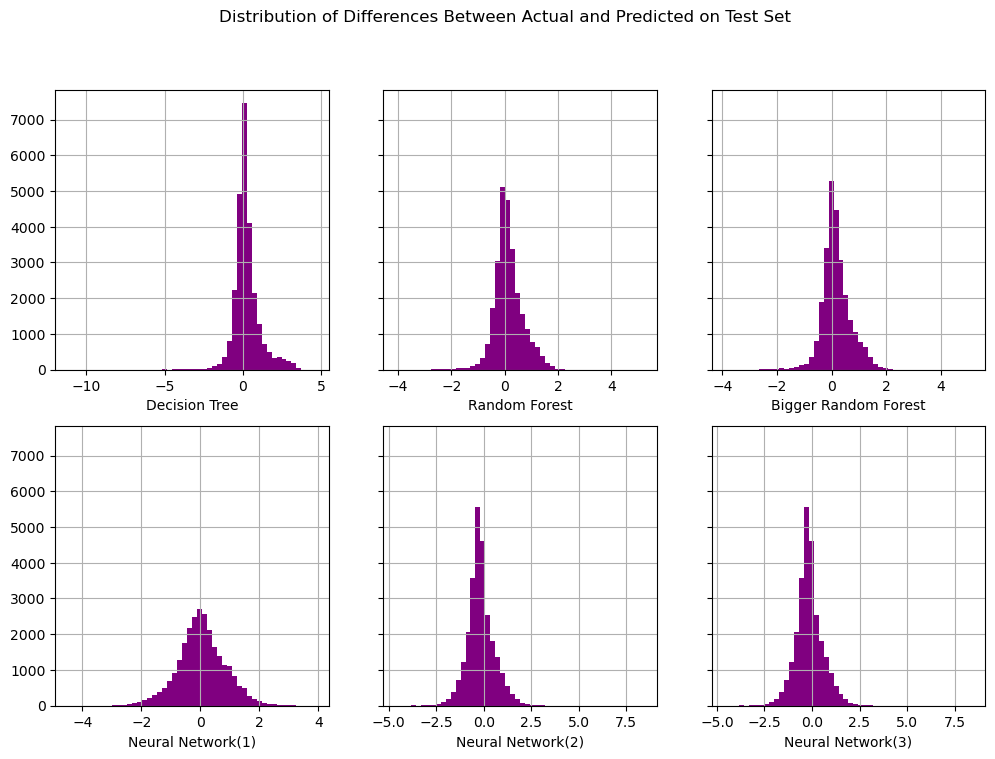

In [278]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharey=True)
plt.suptitle("Distribution of Differences Between Actual and Predicted on Test Set")

axes[0][0].set_xlabel("Decision Tree")
actual_preds_diff_decision_tree_test_data.hist(ax=axes[0][0], bins=50, color="purple")

axes[0][1].set_xlabel("Random Forest")
actual_preds_diff_random_forest_test_data.hist(ax=axes[0][1], bins=50, color="purple")

axes[0][2].set_xlabel("Bigger Random Forest")
actual_preds_diff_bigger_random_forest_test_data.hist(ax=axes[0][2], bins=50, color="purple")

axes[1][0].set_xlabel("Neural Network(1)")
actual_preds_diff_ann_model_1_test_data.hist(ax=axes[1][0], bins=50, color="purple")

axes[1][1].set_xlabel("Neural Network(2)")
actual_preds_diff_ann_model_2_test_data.hist(ax=axes[1][1], bins=50, color="purple")

axes[1][2].set_xlabel("Neural Network(3)")
actual_preds_diff_ann_model_2_test_data.hist(ax=axes[1][2], bins=50, color="purple")

plt.show()

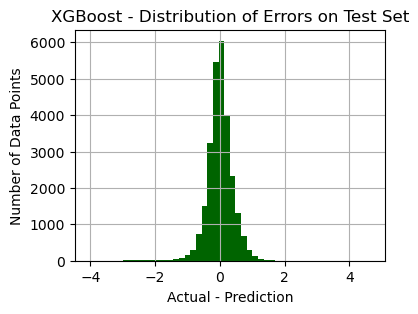

In [280]:
plt.figure(figsize=(4, 3))
plt.hist(x=actual_preds_diff_xgboost_test_data, bins=50, color='darkgreen')
plt.xlabel("Actual - Prediction")
plt.ylabel("Number of Data Points")
plt.title("XGBoost - Distribution of Errors on Test Set")
plt.grid(True)
plt.show()

In [300]:
ann_model_3_history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

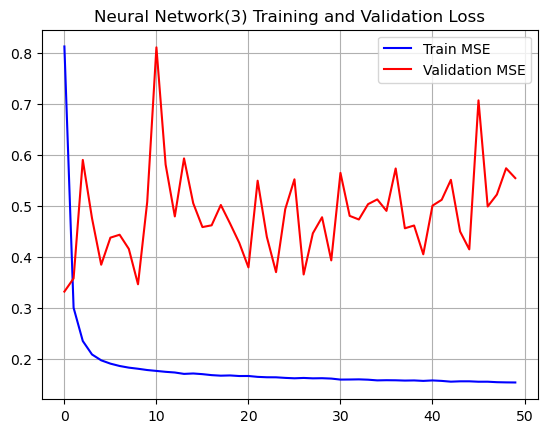

In [309]:
plt.plot(ann_model_3_history.history["mse"], color='blue', label="Train MSE")
plt.plot(ann_model_3_history.history["val_mse"], color='red', label="Validation MSE")
plt.legend(loc="upper right")
plt.title("Neural Network(3) Training and Validation Loss")
plt.grid(True)
plt.show()

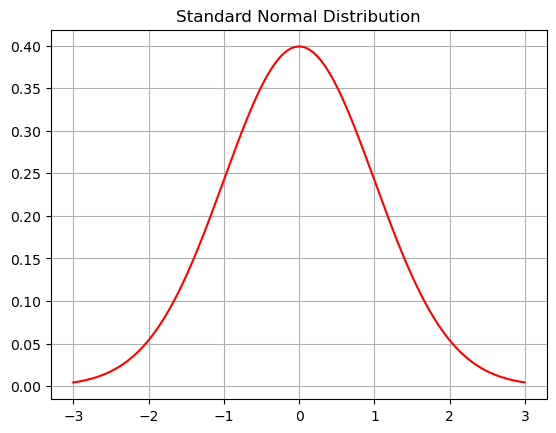

In [291]:
x_axis = np.arange(-3, 3, 0.01)

from scipy.stats import norm
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), color="red")
plt.title("Standard Normal Distribution")
plt.grid(True)

In [319]:
price_and_mileage_df = cars_df[["log(price)", "mileage"]]
price_and_mileage_df.rename(columns={ "log(price)": "log(Price)", 
                                      "mileage": "Mileage"},
                            inplace=True)
price_mileage_correlation_matrix = price_and_mileage_df.corr()
price_mileage_correlation_matrix

/tmp/ipykernel_32/3031992029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_and_mileage_df.rename(columns={ "log(price)": "log(Price)",


,log(Price),Mileage
log(Price),1.000000,-0.541172
Mileage,-0.541172,1.000000


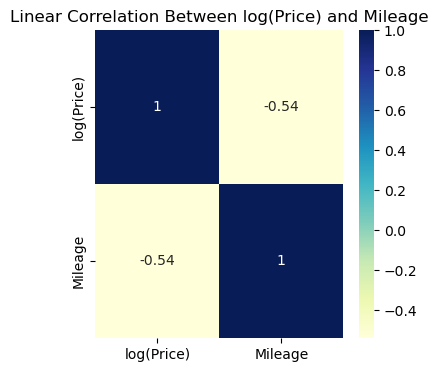

In [342]:
plt.figure(figsize=(4,4))
sns.heatmap(price_mileage_correlation_matrix, annot=True, cmap=plt.cm.YlGnBu)
plt.title("Linear Correlation Between log(Price) and Mileage")
plt.show()

In [325]:
price_and_year_df = cars_df[["log(price)", "year"]]
price_and_year_df.rename(columns={ "log(price)": "log(Price)", 
                                      "year": "Year Made"},
                            inplace=True)
price_year_correlation_matrix = price_and_year_df.corr()
price_year_correlation_matrix

/tmp/ipykernel_32/3140208116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_and_year_df.rename(columns={ "log(price)": "log(Price)",


,log(Price),Year Made
log(Price),1.000000,0.611393
Year Made,0.611393,1.000000


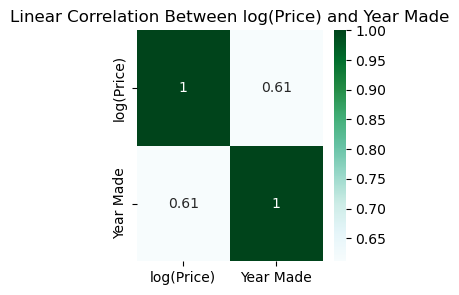

In [340]:
plt.figure(figsize=(4,4))
sns.heatmap(price_year_correlation_matrix, annot=True, cmap=plt.cm.BuGn)
plt.title("Linear Correlation Between log(Price) and Year Made")
plt.show()